<a href="https://colab.research.google.com/github/BiancaStadl/Bachelorarbeit/blob/main/01_working_trial_tfhub_multi_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Citation: Using GPU in colab and Tensorflow: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.775881347999984
GPU (s):
0.08662524700002905
GPU speedup over CPU: 66x


Hier umgesetzt:
laut Doku von https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4 und https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


general tutorial: https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en

German pre-trained embeddings:
* https://nlp.johnsnowlabs.com/2021/05/20/distilbert_base_multilingual_cased_xx.html -> maybe

* multilingual https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4 inklusive pre-processing (extra laden, siehe Tut) https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3 

Was passiert hier?
Multilingual bert vom TensorFlowHub wird verwendet (noch nicht huggingface). Die Modelle vom TensorFlowHub sind leichter einzubinden, weil z. B. der eigenen PreProcessor geladen werden kann und man nicht händisch die Tokens CLS und SEP etc. hinzufügen muss, Masking passiert auch durch den PreProcessor, es wird demnach schon einfach viel im Vorhinein zur Verfügung gestellt, damit man ganz einfach fine-tunen kann. Damit beginne ich mal, bevor ich Huggingface mache.
also, ganz simpel: https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=zh-TW#the_preprocessing_model

mit mehr Einstellungen: https://www.tensorflow.org/text/tutorials/fine_tune_bert?hl=zh-TW#preprocess_the_data und auch https://www.tensorflow.org/text/tutorials/bert_glue?hl=zh-TW


In [3]:

import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from keras import losses
from tensorflow import keras 
from keras import optimizers 
from keras import metrics 

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing


In [4]:
import tensorflow_hub as hub

In [5]:
url = "https://github.com/uds-lsv/GermEval-2018-Data/archive/master.zip"

dataset = tf.keras.utils.get_file("GermEval-2018-Data-master.zip", url, 
                                   extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'GermEval-2018-Data-master')


In [6]:
#os.listdir(dataset_dir)

In [7]:
training_file = os.path.join(dataset_dir, 'germeval2018.training.txt')
#with open(training_file) as f:
 # print(f.read())

#print()

testing_file = os.path.join(dataset_dir, 'germeval2018.test.txt')


In [8]:
def remove_clutter(string):
   string = re.sub("@[^\s]+"," ",string)
   string = re.sub("#[^\s]+"," ", string)
   string = re.sub("\u00a9"," ", string)
   string = re.sub("\u00ae"," ", string)
   string = re.sub("[\u2000-\u3300]"," ", string)
   string = re.sub("\ud83c[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83d[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83e[\ud000-\udfff]"," ", string)
   string = re.sub("😜", " ",string)
   string = re.sub("🍫", " ",string)
   string = re.sub("😁", " ",string)
   string = re.sub("🐖", " ",string)
   string = re.sub("😡", " ",string)
   string = re.sub("😇", " ",string)
   string = re.sub("😬", " ",string)
   string = re.sub("😃", " ",string)
   string = re.sub("😂", " ",string)
   string = re.sub("💙", " ",string)  
   string = re.sub("😛", " ",string)
   string = re.sub("🙏", " ",string)
   string = re.sub("👍", " ",string)
   string = re.sub("🖕", " ",string)
   string = re.sub("😉", " ",string)
   string = re.sub("💩", " ",string)
   string = re.sub("🤢", " ",string)
   string = re.sub("👏", " ",string)
   string = re.sub("😨", " ",string)
   string = re.sub("🤣", " ",string)
   string = re.sub("🤡", " ",string)
   string = re.sub("😈", " ",string)
   string = re.sub("💃🏽", " ",string)
   string = re.sub("👹", " ",string)
   string = re.sub("🤘", " ",string)
   string = re.sub("😱", " ",string)
   string = re.sub("🤔", " ",string) 
   string = re.sub("🌈", " ",string) 
   string = re.sub("💕", " ",string) 
   string = re.sub("👩‍❤️‍👩", " ",string) 
   string = re.sub("😍", " ",string) 
   string = re.sub("👆", " ",string) 
   string = re.sub("😖", " ",string) 
   string = re.sub("👇", " ",string) 
   string = re.sub("🔥", " ",string) 
   string = re.sub("😘", " ",string) 
   string = re.sub("🎉", " ",string) 
   string = re.sub("🤬", " ",string) 
   string = re.sub("👊", " ",string)
   string = re.sub("🇩🇪", " ",string)  
   string = re.sub("💔", " ",string)
   string = re.sub("🙈", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🐟", " ",string)
   string = re.sub("🛶", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😓", " ",string)
   string = re.sub("😳", " ",string)
   string = re.sub("🚀", " ",string)
   string = re.sub("👎", " ",string)
   string = re.sub("😎", " ",string)
   string = re.sub("🐸", " ",string)
   string = re.sub("📈", " ",string)
   string = re.sub("🙂", " ",string)
   string = re.sub("😅", " ",string)
   string = re.sub("😆", " ",string)
   string = re.sub("🙎🏿", " ",string)
   string = re.sub("👎🏽", " ",string)
   string = re.sub("🤭", " ",string)
   string = re.sub("😤", " ",string)
   string = re.sub("😚", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😲", " ",string)
   string = re.sub("🤮", " ",string)
   string = re.sub("🙄", " ",string)
   string = re.sub("🤑", " ",string)
   string = re.sub("🎅", " ",string)
   string = re.sub("👋", " ",string)
   string = re.sub("💪", " ",string)
   string = re.sub("😄", " ",string)
   string = re.sub("🧐", " ",string)
   string = re.sub("😠", " ",string)
   string = re.sub("🎈", " ",string)
   string = re.sub("🚂", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("🚇", " ",string)
   string = re.sub("🚊", " ",string)
   string = re.sub("🤷", " ",string)
   string = re.sub("😥", " ",string)
   string = re.sub("🙃", " ",string)
   string = re.sub("🔩", " ",string)
   string = re.sub("🔧", " ",string)
   string = re.sub("🔨", " ",string)
   string = re.sub("🛠", " ",string)
   string = re.sub("💓", " ",string)
   string = re.sub("💡", " ",string)
   string = re.sub("🍸", " ",string)
   string = re.sub("🥃", " ",string)
   string = re.sub("🥂", " ",string)
   string = re.sub("😷", " ",string)
   string = re.sub("🤐", " ",string)
   string = re.sub("🌎", " ",string)
   string = re.sub("👑", " ",string)
   string = re.sub("🤛", " ",string)
   string = re.sub("😀", " ",string)
   string = re.sub("🛤", " ",string)
   string = re.sub("🎄", " ",string)
   string = re.sub("📴", " ",string)
   string = re.sub("🌭", " ",string)
   string = re.sub("🤕", " ",string)
   string = re.sub("😭", " ",string)
   string = re.sub("🍾", " ",string)
   string = re.sub("🍞", " ",string)
   string = re.sub("🤦", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🕯️", " ",string)

   string = re.sub("OTHER|OFFENSE|ABUSE|INSULT"," ",string)
   return string

In [9]:
statementsForTraining = []
sentimentsForTraining = []

fileToRead = open(training_file, 'r')

while True:
  #next line in file
  line = fileToRead.readline()

  if line == "":
   break

  findSentiment = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)
      

  statementsForTraining.append(line)

  if findSentiment.group(0) == "OTHER":  
    sentimentsForTraining.append(0)
  else:
    sentimentsForTraining.append(1)

  if not line:
    break

 #print("{}: {}".format(count,line.strip()))
  
 # print(sentiment.group(0))
 
fileToRead.close()

training_sentences = statementsForTraining
training_labels = sentimentsForTraining

#print(training_sentences[0:100])
#print(training_labels[9])  

In [10]:

statementsForTesting = []
sentimentsForTesting = []

fileToRead = open(testing_file, 'r')

while True:
 
  line = fileToRead.readline()

  if line == "":
   break

  sent = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)


  statementsForTesting.append(line)
  #print(len(line))

  if sent.group(0) == "OTHER": 
    sentimentsForTesting.append(0)
  else:
    sentimentsForTesting.append(1)

  if not line:
    break


fileToRead.close()


testing_sentences = statementsForTesting
testing_labels = sentimentsForTesting
#print(len(testing_sentences))
#print(testing_sentences)   
#print(statementsForTesting)

maybe also use this https://stackoverflow.com/questions/60120043/optimizer-and-scheduler-for-bert-fine-tuning 

laut Doku von https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4 und https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3

Erster Versuch mit Multilingual

In [11]:
max_length = 60

In [12]:
!pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.

Für das Pre-Processing gibts Code in der Coku https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3 

In meinem Fall: für mehrere Input-Segments und nicht nur ein einzelnes

In [13]:
# preprocessor = hub.load(
#     "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")

# preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")



In [14]:
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM

dieser Code ist direkt von der tfhub-Doku, Mischung aus Classify-Tut und multi-Documentation

In [15]:
def build_simple_sentiment_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweet')
  preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=True)
  outputs = encoder(encoder_inputs)
  pooled_output = outputs["pooled_output"] 
  addedLayers = tf.keras.layers.Dropout(0.1)(pooled_output)#change me
  addedLayers = tf.keras.layers.Dense(90, activation='relu')(addedLayers)#change me
  addedLayers = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(addedLayers)#change me
  return tf.keras.Model(text_input, addedLayers)


In [16]:
modelBERT012502 = build_simple_sentiment_classifier_model()

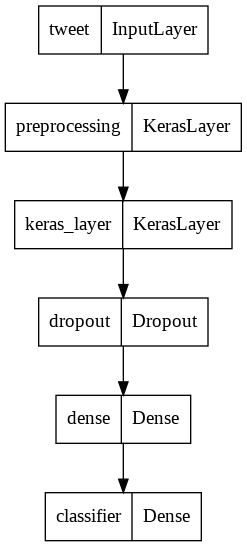

In [17]:
tf.keras.utils.plot_model(modelBERT012502)

als zusätzliche Evaluierungsmetrik -> f1 (Precision, Recall)

In [18]:
import keras.backend as K

def metrics_recall(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))
    possible_positives = K.sum(K.round(K.clip(data_true,0,1)))

    recall = true_positives / (possible_positives+K.epsilon())
    return recall


def metrics_precision(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))

    positives_predicted = K.sum(K.round(K.clip(data_pred,0,1)))
    precision = true_positives / (positives_predicted+K.epsilon())
    return precision


def metrics_f1(data_true, data_pred):
    precision_data = metrics_precision(data_true, data_pred)
    recall_data = metrics_recall(data_true, data_pred)
    return 2*(precision_data*recall_data)/(precision_data+recall_data+K.epsilon())

In [19]:
modelBERT012502.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tweet (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['tweet[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [20]:
#model.layers[1].get_weights()[0].shape

In [21]:
batch_size = 32

the following comes from https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb#scrollTo=P9eP2y9dbw32

In [22]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [23]:
!pip install -q tf-models-official
from official.nlp import optimization
#tensorflow model garden zitieren https://github.com/tensorflow/models


In [24]:
training_epochs = 5

steps_per_epoch = 157
num_train_steps = steps_per_epoch * training_epochs
num_warmup_steps = int(0.1*num_train_steps)


#init_lr = 3e-5
init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [25]:
modelBERT012502.compile(loss=loss, optimizer=optimizer ,metrics=[metrics,metrics_recall,metrics_precision,metrics_f1])

fit works with dataset -> from tensors, but not with from tensor_slices.. why?

In [26]:
modelBERT012502.fit(training_sentences, training_labels, batch_size=batch_size, epochs=training_epochs)

Epoch 1/5
157/157 [==============================] - 167s 891ms/step - loss: 0.5617 - binary_accuracy: 0.7125 - metrics_recall: 0.3223 - metrics_precision: 0.5037 - metrics_f1: 0.3537
Epoch 2/5
157/157 [==============================] - 143s 913ms/step - loss: 0.3909 - binary_accuracy: 0.8235 - metrics_recall: 0.7085 - metrics_precision: 0.7692 - metrics_f1: 0.7189
Epoch 3/5
157/157 [==============================] - 142s 903ms/step - loss: 0.2526 - binary_accuracy: 0.8994 - metrics_recall: 0.8404 - metrics_precision: 0.8575 - metrics_f1: 0.8397
Epoch 4/5
157/157 [==============================] - 144s 918ms/step - loss: 0.1508 - binary_accuracy: 0.9447 - metrics_recall: 0.9174 - metrics_precision: 0.9176 - metrics_f1: 0.9130
Epoch 5/5
157/157 [==============================] - 142s 905ms/step - loss: 0.0893 - binary_accuracy: 0.9693 - metrics_recall: 0.9534 - metrics_precision: 0.9515 - metrics_f1: 0.9497


In [27]:
#(loss,metrics, metrics_recall, metrics_precision,
#metrics_f1) = model.evaluate(testing_sentences, testing_labels, verbose=1)
#(metrics) = model.evaluate(testing_sentences[50:110], testing_labels[50:110], verbose=1)

In [28]:
BERTPredict=modelBERT012502.predict(x=testing_sentences)

In [29]:
#for p in LSTM_predict80AE:
 # print(p)
BERT_pred_thresh = np.where(BERTPredict >= 0.5, 1, 0)

In [30]:
prediction_rounded = np.round(BERTPredict)

# for p in prediction_rounded:
#   print(p)


#print(nptesting_labels[200:210])

https://deeplizard.com/learn/video/km7pxKy4UHU

Quelle der def plot_confusion_matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py 

In [31]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [32]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
cm = confusion_matrix(y_true=testing_labels, y_pred=BERT_pred_thresh)

In [34]:
plot_labels = ['no hatespeech','hatespeech']

Confusion matrix, without normalization
[[2099  231]
 [ 574  628]]


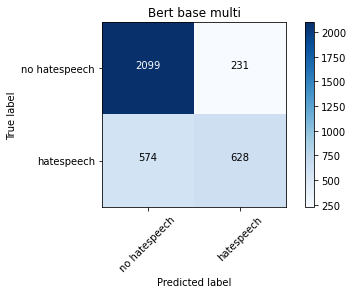

In [35]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='Bert base multi')

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy_test = accuracy_score(testing_labels, BERT_pred_thresh)

In [38]:
accuracy_test

0.772083805209513